In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import os

In [19]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [20]:
def transform_bit(state):
    newbit = (state ^(state >> 2) ^ (state >>4) ^(state >> 13)) &1
    state = (state >> 1) | (newbit << 13)
    return state
    

In [30]:
M = 50
N = 50*2**14
state = np.random.randint(2**14, size=M)
states = np.zeros((N, state.shape[0]))
for i in tqdm(range(N)):
    for j in range(M):
        state[j] = transform_bit(state[j])
        states[i,j] = state[j]

  0%|          | 0/819200 [00:00<?, ?it/s]

100%|██████████| 819200/819200 [01:08<00:00, 11921.29it/s]


In [31]:
print(scipy.stats.shapiro(states.sum(axis=1)))

ShapiroResult(statistic=0.9999695420265198, pvalue=0.0007069935672916472)


/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [32]:
white = states.sum(axis=1)/(M*(2**14-1))
white = 2*(white-0.5)

In [33]:
clock_cycle = 64*8e-9

In [34]:
sum_brown = 0
brown_noise = np.zeros((white.shape[0]))
pink_noise = np.zeros((white.shape[0]-1))
window=10000
factor = 0.05
for i in range(brown_noise.shape[0]):
    brown_noise[i] = factor*(white[i-window:i+1].sum())
pink_noise = np.diff(white)

In [35]:
f_white, power_white = scipy.signal.periodogram(white, fs=1/clock_cycle, window='hamming', nfft=(2**15))
f_brown, power_brown = scipy.signal.periodogram(brown_noise, fs=1/clock_cycle, window='hamming', nfft=(2**15))
f_pink, power_pink = scipy.signal.periodogram(pink_noise, fs=1/clock_cycle, window='hamming', nfft=(2**15))

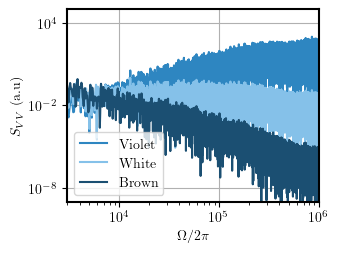

In [36]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
fig.set_size_inches(2.5*1.3, 2.5, forward=True)

plt.plot(f_pink, 2000*power_pink/power_white.max(), color=colors[0], label="Violet")
plt.plot(f_white, power_white/power_white.max(), color=colors[1], label="White")
plt.plot(f_brown, 0.08*power_brown/power_white.max(), color=colors[2], label="Brown")
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\Omega/2\pi$')
plt.ylabel(r'$S_{VV}$ (a.u)')

plt.xlim([3e3, 1e6])
plt.yticks([1e-8, 1e-2, 1e4])
plt.ylim([1e-9, 1e5])
plt.legend()
plt.grid()
plt.savefig('../../plots/Chapter 6/noise.pdf', dpi=300, bbox_inches = 'tight')
plt.show()
